In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mlelec.data.dataset import (
    precomputed_molecules,
    MoleculeDataset,
    MLDataset,
    get_dataloader,
)
import torch
from ase.io import read
import ase
from mlelec.models.linear import LinearTargetModel
from mlelec.features.acdc import compute_features_for_target

import matplotlib.pyplot as plt
from IPython.utils import io

In [3]:
import sys
import pyscf, pyscfad

print(sys.version_info)
print(pyscf.__version__)
print(pyscfad.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
2.3.0
0.1.2


In [4]:
# import sys
# import os
# class HiddenPrints:
#     def __enter__(self):
#         self._original_stdout = sys.stdout
#         sys.stdout = open(os.devnull, 'w')
#         sys._jupyter_stdout = sys.stdout

#     def __exit__(self, exc_type, exc_val, exc_tb):
#         sys.stdout.close()
#         sys.stdout = self._original_stdout
#         sys._jupyter_stdout = sys.stdout

In [5]:
water_data = MoleculeDataset(
    mol_name="water_1000",
    frame_slice=slice(0, 100),
    device="cuda",
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment"],
)
ml_data = MLDataset(
    molecule_data=water_data,
    device="cuda",
    model_strategy="coupled",
    shuffle=True,
    shuffle_seed=5380,
)  # train_frac=0.5, val_frac=0.1,) #target=["fock", "dipole_moment"])

# ml_data._shuffle(5380)
ml_data._split_indices(train_frac=0.7, val_frac=0.2, test_frac=0.1)
# assumed args.model_type = 'acdc'
if ml_data.features is None:
    ml_data._set_features(compute_features_for_target(ml_data, device="cuda"))

train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="tensor")

Loading structures
examples/data/water_1000/sto-3g/fock.hickle
examples/data/water_1000/sto-3g/dipole_moment.hickle
Computing features with default hypers


/home/nigam/miniconda3/lib/python3.11/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


## 1. Learn Hamiltonian then predict dipole

In [83]:
model = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=False, device="cuda"
)

In [84]:
from cmath import inf

best = inf
early_stop_criteria = 50

In [85]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=10, verbose=True
)
import mlelec.metrics as mlmetrics

val_interval = 10
loss_fn = getattr(mlmetrics, "L2_loss")
losses = []
early_stop_count = 0

In [86]:
for epoch in range(800):
    # train_pred = []
    # target=[]
    model.train(True)
    train_loss = 0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        pred = model(data["input"], return_type="tensor", batch_indices=data["idx"])
        # target.append(data['output'])
        # train_pred.append(pred)
        loss = loss_fn(pred, data["output"])
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch % val_interval == 0:
        # val_pred = []
        # val= []
        val_loss = 0
        for i, data in enumerate(val_dl):
            pred = model(data["input"], return_type="tensor", batch_indices=data["idx"])
            vloss = loss_fn(pred, data["output"])
            val_loss += vloss.item()
            # val.append(data['output'])
            # val_pred.append(pred)
        new_best = val_loss < best
        if new_best:
            best = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

        print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")

Epoch 0, train loss 471.1422502257118
Epoch 0 val loss 461.01390198046283
Epoch 10, train loss 153.5696222241118
Epoch 10 val loss 134.30316721645727
Epoch 20, train loss 6.020242243384347
Epoch 20 val loss 4.863695816885546
Epoch 30, train loss 2.419698748460661
Epoch 30 val loss 2.8194324528945214
Epoch 40, train loss 2.1079256938928546
Epoch 40 val loss 2.1984906077315327
Epoch 50, train loss 1.7910084999452782
Epoch 50 val loss 1.7041997267401958
Epoch 60, train loss 1.4849439037005143
Epoch 60 val loss 1.2131049681817034
Epoch 70, train loss 1.186095684461929
Epoch 70 val loss 1.2273000623716384
Epoch 80, train loss 1.226056306528393
Epoch 80 val loss 1.043814922785987
Epoch 90, train loss 1.1240874296848944
Epoch 90 val loss 0.831274960749046
Epoch 100, train loss 1.0713700891164009
Epoch 100 val loss 0.7909029991734098
Epoch 110, train loss 1.0356319251705617
Epoch 110 val loss 0.5591677811501039
Epoch 120, train loss 1.0784276433607898
Epoch 120 val loss 0.8763550590904681
Epoc

KeyboardInterrupt: 

Text(0, 0.5, 'MSE \\ a.u.')

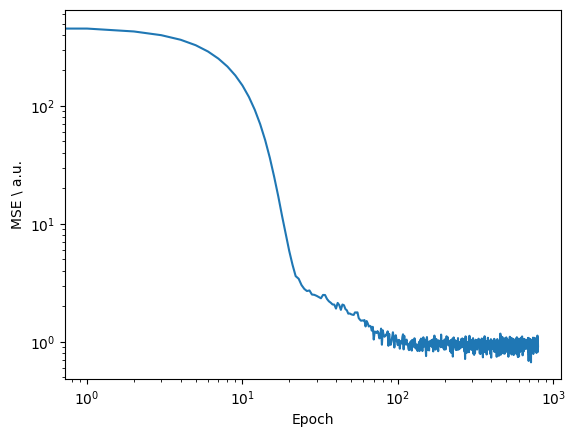

In [ ]:
import numpy as np

plt.loglog(np.asarray(losses) / len(ml_data.train_idx))
plt.xlabel("Epoch")
plt.ylabel("MSE \ a.u.")

### Input model prediction into pyscf to compute dipole moment 

In [ ]:
import os

os.environ["PYSCFAD_BACKEND"] = "torch"

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

In [ ]:
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics

In [ ]:
def compute_dipole_moment(frames, fock_predictions, overlaps):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [ ]:
# TEST set

# with HiddenPrints():
with io.capture_output() as captured:
    fock_predictions = model.forward(ml_data.feat_test, return_type="tensor")
    # convert prediction back to pyscf order
    fock_predictions = unfix_orbital_order(
        fock_predictions,
        ml_data.test_frames,
        ml_data.molecule_data.aux_data["orbitals"],
    )

    dipole_predictions = compute_dipole_moment(
        ml_data.test_frames,
        fock_predictions,
        ml_data.molecule_data.aux_data["overlap"][ml_data.test_idx],
    )
    # very imp to pass the right overlap matrix


error = mlmetrics.L2_loss(
    dipole_predictions, ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]
)
print("(TEST) MSE on dipole", error / len(dipole_predictions))

(TEST) MSE on dipole tensor(0.3787, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
# Entire dataset
with io.capture_output() as captured:
    fock_predictions = model.forward(ml_data.features, return_type="tensor")
    # convert prediction back to pyscf order
    fock_predictions = unfix_orbital_order(
        fock_predictions, ml_data.structures, ml_data.molecule_data.aux_data["orbitals"]
    )
    dipole_predictions = compute_dipole_moment(
        ml_data.structures, fock_predictions, ml_data.molecule_data.aux_data["overlap"]
    )
error = mlmetrics.L2_loss(
    dipole_predictions, ml_data.molecule_data.target["dipole_moment"]
)
print("MSE on dipole", error / len(dipole_predictions))

MSE on dipole tensor(0.2696, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


## 2. Indirect learning of dipole moment through pyscfad 

In [ ]:
import mlelec.metrics as mlmetrics

In [ ]:
import os

os.environ["PYSCFAD_BACKEND"] = "torch"

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

Using PyTorch backend.


/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [ ]:
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics

In [ ]:
import warnings


def instantiate_mf(ml_data: MLDataset, fock_predictions=None, batch_indices=None):
    if fock_predictions is not None and len(batch_indices) != len(fock_predictions):
        warnings.warn("Converting shapes")
        fock_predictions = fock_predictions.reshape(1, *fock_predictions.shape)
    if fock_predictions is None:
        fock_predictions = torch.zeros_like(ml_data.target.tensor[batch_indices])

    mfs = []
    fockvar = []
    for i, idx in enumerate(batch_indices):
        mol = _instantiate_pyscf_mol(ml_data.structures[idx])
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )
        mfs.append(mf)
        fockvar.append(fock)
    return mfs, torch.stack(fockvar)


def compute_dipole_moment_from_mf(mfs, fock_vars, overlaps):
    # compute dipole moment for each molecule in batch
    dipoles = []
    for i in range(len(mfs)):
        mf = mfs[i]
        fock = fock_vars[i]
        overlaps[i] = overlaps[i].to(fock)
        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)


def compute_batch_dipole_moment(ml_data: MLDataset, batch_fockvars, batch_indices, mfs):
    # Convert fock predictions back to pyscf order
    # Compute dipole moment for each molecule in batch
    batch_frames = [ml_data.structures[i] for i in batch_indices]
    batch_fock = unfix_orbital_order(
        batch_fockvars, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][batch_indices].to(
        batch_fock
    )
    batch_mfs = [mfs[i] for i in batch_indices]
    dipoles = compute_dipole_moment_from_mf(batch_mfs, batch_fock, batch_overlap)
    return dipoles

In [ ]:
with io.capture_output() as captured:
    all_mfs, fockvars = instantiate_mf(
        ml_data,
        fock_predictions=None,
        batch_indices=list(range(len(ml_data.structures))),
    )

In [ ]:
from cmath import inf

best = inf
early_stop_criteria = 10

In [ ]:
model = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=False, device="cuda"
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=10, verbose=True
)

val_interval = 10  # When to validate the model

In [ ]:
loss_fn = getattr(mlmetrics, "L2_loss")
losses = []
early_stop_count = 0
for epoch in range(800):
    model.train(True)
    train_loss = 0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        batch_indices = data["idx"]
        # print(batch_indices)
        train_focks = model(
            data["input"], return_type="tensor", batch_indices=batch_indices
        ).type(torch.float64)
        with io.capture_output() as captured:
            train_dip_pred = compute_batch_dipole_moment(
                ml_data, train_focks, batch_indices=batch_indices, mfs=all_mfs
            )
        loss = loss_fn(
            train_dip_pred, ml_data.molecule_data.target["dipole_moment"][batch_indices]
        )
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            batch_indices = data["idx"]
            val_focks = model(
                data["input"], return_type="tensor", batch_indices=batch_indices
            ).type(torch.float64)
            with io.capture_output() as captured:
                val_dip_pred = compute_batch_dipole_moment(
                    ml_data, val_focks, batch_indices=batch_indices, mfs=all_mfs
                )

            vloss = loss_fn(
                val_dip_pred,
                ml_data.molecule_data.target["dipole_moment"][batch_indices],
            )
            val_loss += vloss.item()
        new_best = val_loss < best
        if new_best:
            best = val_loss
            # torch.save(model.state_dict(), 'best_model_dipole.pt')
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

        print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")

Epoch 0, train loss 4.7234631343690525
Epoch 0 val loss 0.5009249111702158
Epoch 10, train loss 0.12233480542107343
Epoch 10 val loss 0.07607226597589022
Epoch 20, train loss 0.0671454152602597
Epoch 20 val loss 0.05426086619676726
Epoch 30, train loss 0.06057652705550447
Epoch 30 val loss 0.053444889243728394
Epoch 40, train loss 0.07045082210620911
Epoch 40 val loss 0.11526813719342328
Epoch 50, train loss 0.052494894499576394
Epoch 50 val loss 0.03088410988041648
Epoch 60, train loss 0.044533690385070886
Epoch 60 val loss 0.025156641535927525
Epoch 70, train loss 0.03901671014634406
Epoch 70 val loss 0.022674010766148996
Epoch 80, train loss 0.02512234538221762
Epoch 80 val loss 0.036093141939436774
Epoch 90, train loss 0.024097809138107208
Epoch 90 val loss 0.022499076981467907
Epoch 100, train loss 0.02650963338031376
Epoch 100 val loss 0.01788050025811151
Epoch 110, train loss 0.021045868340015112
Epoch 110 val loss 0.013018676762912483
Epoch 120, train loss 0.021396714919648663


Text(0, 0.5, 'MSE')

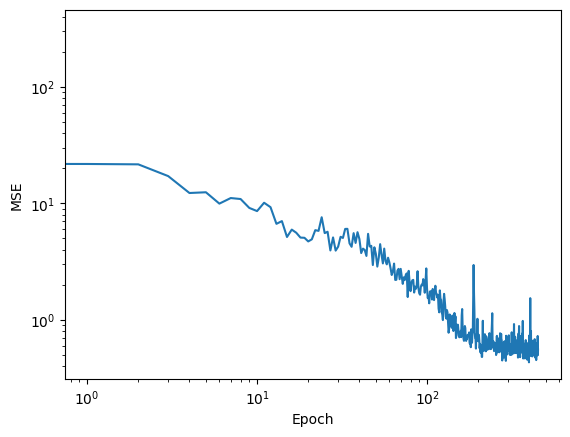

In [ ]:
plt.loglog(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [ ]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx
    ).type(torch.float64)
    test_dip_pred = compute_batch_dipole_moment(
        ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )

error = mlmetrics.L2_loss(
    test_dip_pred, ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]
)
print("(TEST) MSE on dipole", error / len(test_dip_pred))

(TEST) MSE on dipole tensor(0.0031, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


What about the loss on the Hamiltonian which is not directly trained on? 

In [ ]:
# Error on canonical ordered fock matrix
mlmetrics.L2_loss(test_fock_predictions, ml_data.target.tensor[ml_data.test_idx]) / len(
    test_fock_predictions
)

tensor(497.8821, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

### TODO : Add loss on the intermediate fock matrix predictions to the overall loss term 

## We can overfit on just rotated structures 

In [ ]:
water_data = MoleculeDataset(
    mol_name="water_rotated",
    frame_slice=slice(0, 100),
    device="cuda",
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment"],
)
ml_data = MLDataset(molecule_data=water_data, device="cuda", model_strategy="coupled")

# ml_data._shuffle(random_seed=5380)
ml_data._split_indices(train_frac=0.4, val_frac=0.33)
# assumed args.model_type = 'acdc'
if ml_data.features is None:
    ml_data._set_features(compute_features_for_target(ml_data, device="cuda"))

Loading structures
examples/data/water_rotated/sto-3g/fock.hickle
examples/data/water_rotated/sto-3g/dipole_moment.hickle
Computing features with default hypers


/home/nigam/miniconda3/lib/python3.11/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


In [ ]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="tensor")
# next(iter(train_dl))

### training on rotated structures 

In [ ]:
model = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=False, device="cuda"
)

In [ ]:
from cmath import inf

best = inf
early_stop_criteria = 10

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=10, verbose=True
)
import mlelec.metrics as mlmetrics

val_interval = 10
loss_fn = getattr(mlmetrics, "L2_loss")
losses = []
early_stop_count = 0

In [ ]:
for epoch in range(800):
    # train_pred = []
    # target=[]
    model.train(True)
    train_loss = 0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        pred = model(data["input"], return_type="tensor", batch_indices=data["idx"])
        # target.append(data['output'])
        # train_pred.append(pred)
        loss = loss_fn(pred, data["output"])
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch % val_interval == 0:
        # val_pred = []
        # val= []
        val_loss = 0
        for i, data in enumerate(val_dl):
            pred = model(data["input"], return_type="tensor", batch_indices=data["idx"])
            vloss = loss_fn(pred, data["output"])
            val_loss += vloss.item()
            # val.append(data['output'])
            # val_pred.append(pred)
        new_best = val_loss < best
        if new_best:
            best = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

        print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")

Epoch 0, train loss 480.6221471109374
Epoch 0 val loss 479.6697718800906
Epoch 10, train loss 471.067940931348
Epoch 10 val loss 470.07432046560285
Epoch 20, train loss 460.5452746793023
Epoch 20 val loss 459.41386976932336
Epoch 30, train loss 448.51430957752297
Epoch 30 val loss 447.2212151794173
Epoch 40, train loss 434.8163762364184
Epoch 40 val loss 433.35173403945134
Epoch 50, train loss 419.394049535435
Epoch 50 val loss 417.75839236533676
Epoch 60, train loss 402.31622244719415
Epoch 60 val loss 400.5242073677908
Epoch 70, train loss 383.78575865653283
Epoch 70 val loss 381.8637295122723
Epoch 80, train loss 364.1001015139956
Epoch 80 val loss 362.08097041657
Epoch 90, train loss 343.5972824317196
Epoch 90 val loss 341.51489354079655
Epoch 100, train loss 322.60118737197865
Epoch 100 val loss 320.48553902797124
Epoch 110, train loss 301.38706441313224
Epoch 110 val loss 299.2625421243271
Epoch 120, train loss 280.17292045612527
Epoch 120 val loss 278.05829901281874
Epoch 130, t

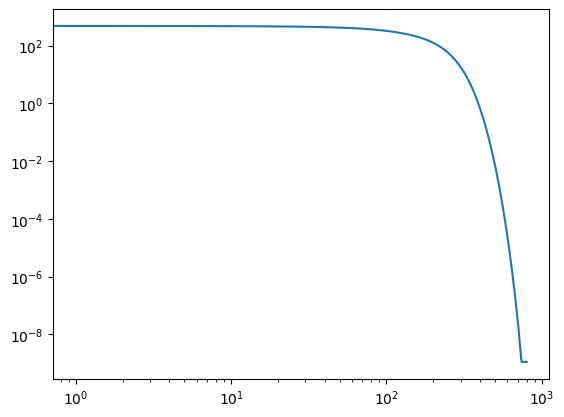

In [ ]:
import matplotlib.pyplot as plt

plt.loglog(losses)

### Input model prediction into pyscf to compute dipole moment 

In [ ]:
import os

os.environ["PYSCFAD_BACKEND"] = "torch"

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

Using PyTorch backend.


/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [ ]:
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics

In [ ]:
import sys
import os


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")
        sys._jupyter_stdout = sys.stdout

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        sys._jupyter_stdout = sys.stdout

In [ ]:
def compute_dipole_moment(frames, fock_predictions, overlaps):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [ ]:
# TEST set

# with HiddenPrints():
with io.capture_output() as captured:
    fock_predictions = model.forward(ml_data.feat_test, return_type="tensor")
    # convert prediction back to pyscf order
    fock_predictions = unfix_orbital_order(
        fock_predictions,
        ml_data.test_structures,
        ml_data.molecule_data.aux_data["orbitals"],
    )

    dipole_predictions = compute_dipole_moment(
        ml_data.test_structures,
        fock_predictions,
        ml_data.molecule_data.aux_data["overlap"][ml_data.test_idx],
    )
    # very imp to pass the right overlap matrix


error = mlmetrics.L2_loss(
    dipole_predictions, ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]
)
print("(TEST) MSE on dipole", error / len(dipole_predictions))

NameError: name 'model' is not defined

In [ ]:
# Entire dataset
with io.capture_output() as captured:
    fock_predictions = model.forward(ml_data.features, return_type="tensor")
    # convert prediction back to pyscf order
    fock_predictions = unfix_orbital_order(
        fock_predictions, ml_data.structures, ml_data.molecule_data.aux_data["orbitals"]
    )
    dipole_predictions = compute_dipole_moment(
        ml_data.structures, fock_predictions, ml_data.molecule_data.aux_data["overlap"]
    )

In [ ]:
error = mlmetrics.L2_loss(
    dipole_predictions, ml_data.molecule_data.target["dipole_moment"]
)
print("MSE on dipole", error / len(dipole_predictions))

MSE on dipole tensor(1.3298e-12, device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)


### test equivariance of prediction/features 

In [ ]:
import hickle

rotations = hickle.load("examples/data/water_rotated/rotations.hickle")
r1 = model.forward(ml_data.features, return_type="coupled_blocks")

In [ ]:
r1 = ml_data.features

In [ ]:
from mlelec.utils.metatensor_utils import labels_where
from mlelec.utils.symmetry import _wigner_d_real
import numpy as np
from metatensor import Labels

for i, (k, b) in enumerate(r1.items()):
    unrot_idx = labels_where(
        b.samples,
        selection=Labels(["structure"], values=np.asarray([[0]]).reshape(-1, 1)),
        return_idx=True,
    )[-1]
    rot_idx = labels_where(
        b.samples,
        selection=Labels(
            ["structure"], values=np.asarray([[ml_data.test_idx]]).reshape(-1, 1)
        ),
        return_idx=True,
    )[-1]
    # L = k['L']
    L = k["spherical_harmonics_l"]
    wd = _wigner_d_real(L, *rotations[ml_data.test_idx - 1]).to(b.values)
    if torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]) > 1e-7:
        print(torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]))

### Indirect learning of dipole moment through pyscfad 

In [ ]:
import mlelec.metrics as mlmetrics

In [ ]:
import warnings


def instantiate_mf(ml_data: MLDataset, fock_predictions, batch_indices):
    if len(batch_indices) != len(fock_predictions):
        warnings.warn("Converting shapes")
        fock_predictions = fock_predictions.reshape(1, *fock_predictions.shape)
    mfs = []
    fockvar = []
    for i, idx in enumerate(batch_indices):
        mol = _instantiate_pyscf_mol(ml_data.structures[idx])
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )
        mfs.append(mf)
        fockvar.append(fock)
    return mfs, torch.cat(fockvar)


def compute_dipole_moment_frommf(mfs, fock_vars, overlaps):
    print(fock_vars.dtype, overlaps.dtype)
    dipoles = []
    for i in range(len(mfs)):
        mf = mfs[i]
        fock = fock_vars[i]
        overlaps[i] = overlaps[i].to(fock)
        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [ ]:
def compute_dipole_moment_from_batchidx(
    ml_data: MLDataset, batch_fockvars, batch_indices, mfs
):
    # Convert fock predictions back to pyscf order
    # Compute dipole moment for each molecule in batch
    batch_frames = [ml_data.structures[i] for i in batch_indices]
    batch_fock = unfix_orbital_order(
        batch_fockvars, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][batch_indices].to(
        batch_fock
    )
    print(len(batch_frames), len(batch_fock), len(batch_overlap))
    return compute_dipole_moment_frommf(mfs, batch_fock, batch_overlap)

In [ ]:
from cmath import inf

best = inf
early_stop_criteria = 10

In [ ]:
model = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=False, device="cuda"
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=10, verbose=True
)

val_interval = 10

In [ ]:
train_focks.shape

torch.Size([7, 7])

In [ ]:
loss_fn = getattr(mlmetrics, "L2_loss")
losses = []
early_stop_count = 0
for epoch in range(300):
    model.train(True)
    train_loss = 0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        batch_indices = data["idx"]
        # print(batch_indices)
        train_focks = model(
            data["input"], return_type="tensor", batch_indices=batch_indices
        ).type(torch.float64)
        with io.capture_output() as captured:
            # with HiddenPrints():
            if epoch == 0:
                train_mfs, train_focks = instantiate_mf(
                    ml_data, train_focks, batch_indices
                )
            train_dip_pred = compute_dipole_moment_from_batchidx(
                ml_data, train_focks, batch_indices=batch_indices, mfs=train_mfs
            )
            loss = loss_fn(
                train_dip_pred,
                ml_data.molecule_data.target["dipole_moment"][batch_indices],
            )
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            batch_indices = data["idx"]
            val_focks = model(
                data["input"], return_type="tensor", batch_indices=batch_indices
            ).type(torch.float64)
            with io.capture_output() as captured:
                # with HiddenPrints():
                if epoch == 0:
                    val_mfs, train_focks = instantiate_mf(
                        ml_data, val_focks, batch_indices
                    )
                val_dip_pred = compute_dipole_moment_from_batchidx(
                    ml_data, val_focks, batch_indices=batch_indices, mfs=val_mfs
                )
            vloss = loss_fn(
                val_dip_pred,
                ml_data.molecule_data.target["dipole_moment"][batch_indices],
            )
            val_loss += vloss.item()
        new_best = val_loss < best
        if new_best:
            best = val_loss
            # torch.save(model.state_dict(), 'best_model_dipole.pt')
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

        print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")

Epoch 0, train loss 23.890822617507865
Epoch 0 val loss 23.890827610345298
Epoch 10, train loss 0.25844257845675
Epoch 10 val loss 0.2808343047151666
Epoch 20, train loss 0.07868898373478944
Epoch 20 val loss 0.056642496020292366
Epoch 30, train loss 0.0030995529533909684
Epoch 30 val loss 0.005510526882811492
Epoch 40, train loss 0.014536936556569131
Epoch 40 val loss 0.013285529380427562
Epoch 50, train loss 0.0010134080183643297
Epoch 50 val loss 0.0004910347735883092
Epoch 60, train loss 0.00106229340354553
Epoch 60 val loss 0.001180861165248113
Epoch 70, train loss 0.0004542081681794029
Epoch 70 val loss 0.0003260449352048469
Epoch 80, train loss 4.7677173606573505e-05
Epoch 80 val loss 7.065522318653241e-05
Epoch 90, train loss 7.915291068666748e-05
Epoch 90 val loss 6.283436181653282e-05
Epoch 100, train loss 2.127319029450375e-06
Epoch 100 val loss 4.63705931478635e-06
Epoch 110, train loss 1.0708887809057119e-05
Epoch 110 val loss 8.727589505492225e-06
Epoch 120, train loss 2.

In [ ]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(ml_data.feat_test, return_type="tensor").type(
        torch.float64
    )
    # convert prediction back to pyscf order
    test_mfs, test_focks = instantiate_mf(ml_data, test_fock_predictions, batch_indices)
    test_dip_pred = compute_dipole_moment_from_batchidx(
        ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=test_mfs
    )
    # very imp to pass the right overlap matrix


error = mlmetrics.L2_loss(
    test_dip_pred, ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]
)
print("(TEST) MSE on dipole", error / len(test_dip_pred))

(TEST) MSE on dipole tensor(3.6236e-12, device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)


## Calculate the target dipole moment of water molecule in case data not found

In [94]:
from mlelec.data.pyscf_calculator import calculator

calc = calculator(
    path="examples/data/water_1000/",
    mol_name="water_1000",
    frame_slice=":",
    target=["fock", "dipole_moment", "density"],
)
calc.calculate(basis_set="sto-3g", verbose=1)

In [93]:
calc.save_results(path="examples/data/water_1000/sto-3g/")

1 s
2 s
2 px
2 py
2 pz
1 s
{8: [[1, 0, 0], [2, 0, 0], [2, 1, 1], [2, 1, -1], [2, 1, 0]], 1: [[1, 0, 0]]}
All done, results saved at:  examples/data/water_1000/sto-3g/


/home/nigam/miniconda3/lib/python3.11/site-packages/hickle/lookup.py:1491: SerializedWarning: 'Tensor' type not understood, data is serialized:
  warnings.warn(


In [109]:
for i in range(len(calc.results["fock"])):
    tr = torch.trace(calc.results['density'][i] @ calc.results['overlap'][i])
    if tr-10> 1e-14: 
        print(i, tr-10)

## grad of dipole moment vector if we need it

In [ ]:
# https://stackoverflow.com/questions/62067400/understanding-accumulated-gradients-in-pytorch

In [ ]:
# grad of dipole moment


for ifr, pred in enumerate(predicted_xyz[:]):
    # gradient of the x component of the p vector
    gradients[ifr][:, 0, :] = torch.autograd.grad(
        pred[0], systems[ifr].positions, retain_graph=True
    )[0]
    # gradient of the y component of the p vector
    gradients[ifr][:, 1, :] = torch.autograd.grad(
        pred[1], systems[ifr].positions, retain_graph=True
    )[0]
    # gradient of the z component of the p vector
    gradients[ifr][:, 2, :] = torch.autograd.grad(
        pred[2], systems[ifr].positions, retain_graph=True
    )[0]

NameError: name 'predicted_xyz' is not defined

# Learning Hamiltonian with losses on derived charges/density matrices 

Above we employed two strategies - one to learn the fock matrix directly and then extract the dipole moment, the other to learn the dipole moment through the fock matrix. The latter strategy is more accurate.
Now we test if adding additional constraints such as charges/densities derived from the predicted fock (against those computed from direct pyscf calculations) makes the learning better 

In [13]:
import warnings
import os

os.environ["PYSCFAD_BACKEND"] = "torch"

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics

Using PyTorch backend.


/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [36]:
water_data = MoleculeDataset(
    mol_name="water_1000",
    frame_slice=slice(0, 100),
    device="cuda",
    aux=["overlap", "orbitals"],
    target=["fock", "density"],
)
ml_data = MLDataset(
    molecule_data=water_data,
    device="cuda",
    model_strategy="coupled",
    shuffle=True,
    shuffle_seed=5380,
)  # train_frac=0.5, val_frac=0.1,) #target=["fock", "dipole_moment"])

# ml_data._shuffle(5380)
ml_data._split_indices(train_frac=0.7, val_frac=0.2, test_frac=0.1)
# assumed args.model_type = 'acdc'
if ml_data.features is None:
    ml_data._set_features(compute_features_for_target(ml_data, device="cuda"))

train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="tensor")

Loading structures
examples/data/water_1000/sto-3g/fock.hickle
examples/data/water_1000/sto-3g/density.hickle
Computing features with default hypers


/home/nigam/miniconda3/lib/python3.11/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


In [15]:

def instantiate_mf(ml_data: MLDataset, fock_predictions=None, batch_indices=None):
    if fock_predictions is not None and len(batch_indices) != len(fock_predictions):
        warnings.warn("Converting shapes")
        fock_predictions = fock_predictions.reshape(1, *fock_predictions.shape)
    if fock_predictions is None:
        fock_predictions = torch.zeros_like(ml_data.target.tensor[batch_indices])

    mfs = []
    fockvar = []
    for i, idx in enumerate(batch_indices):
        mol = _instantiate_pyscf_mol(ml_data.structures[idx])
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )
        mfs.append(mf)
        fockvar.append(fock)
    return mfs, torch.stack(fockvar)

In [52]:
def compute_densitymatrix_from_mf(mfs, fock_vars, overlaps):
    # compute dipole moment for each molecule in batch
    density = []
    for i in range(len(mfs)):
        mf = mfs[i]
        fock = fock_vars[i]
        overlaps[i] = overlaps[i].to(fock)
        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm = mf.make_rdm1(mo_coeff, mo_occ)
        density.append(dm)
    return torch.stack(density)


def compute_batch_dm(ml_data: MLDataset, batch_fockvars, batch_indices, mfs, return_pop=False):
    # Convert fock predictions back to pyscf order
    # Compute density matrix for each molecule in batch
    batch_frames = [ml_data.structures[i] for i in batch_indices]
    batch_fock = unfix_orbital_order(
        batch_fockvars, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][batch_indices].to(
        batch_fock
    )
    batch_mfs = [mfs[i] for i in batch_indices]
    density = compute_densitymatrix_from_mf(batch_mfs, batch_fock, batch_overlap)
    population = torch.sum(torch.einsum("bij, bji ->bi", density, batch_overlap), axis=1)
    #This, for each frame is the Trace(overlap @ Density matrix) = number of electrons 
    if return_pop:
        return density, population  
    return density


## Derived density matrix/pop  

In [61]:
model = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=False, device="cuda"
)

In [62]:
from cmath import inf

best = inf
early_stop_criteria = 50

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=10, verbose=True
)
import mlelec.metrics as mlmetrics

val_interval = 10
loss_fn = getattr(mlmetrics, "L2_loss")
losses = []
early_stop_count = 0

In [64]:
with io.capture_output() as captured:
    all_mfs, fockvars = instantiate_mf(
        ml_data,
        fock_predictions=None,
        batch_indices=list(range(len(ml_data.structures))),
    )

In [65]:
def multiple_loss_fn(pred, target, loss_fn:callable):
    #pred, target are dictionaries 
    loss = 0
    for t in pred: 
        for i in range(len(pred[t])):
            loss += loss_fn(pred[t][i], target[t][i])
        return loss

In [66]:
for epoch in range(800):
    # train_pred = []
    # target=[]
    model.train(True)
    train_loss = 0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        batch_indices = data["idx"]
        train_focks = model(
            data["input"], return_type="tensor", batch_indices=batch_indices
        ).type(torch.float64)

        with io.capture_output() as captured:
            train_dm_pred, train_pop = compute_batch_dm(
                ml_data, train_focks, batch_indices=batch_indices, mfs=all_mfs, return_pop=True
            )
        loss = loss_fn(
            train_focks, data["output"]) + loss_fn(train_dm_pred, ml_data.molecule_data.target['density'][batch_indices]) 
        + loss_fn(train_pop, ml_data.molecule_data.target['elec_population'][batch_indices])

        # target.append(data['output'])
        # train_pred.append(pred)
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch % val_interval == 0:
        # val_pred = []
        # val= []
        val_loss = 0
        for i, data in enumerate(val_dl):
            val_focks = model(data["input"], return_type="tensor", batch_indices=data["idx"]).type(torch.float64)
            with io.capture_output() as captured:
                val_dm_pred, val_pop = compute_batch_dm(
                ml_data, val_focks, batch_indices=batch_indices, mfs=all_mfs, return_pop=True
            )
            vloss = loss_fn(val_focks, data["output"]) + loss_fn(val_dm_pred, ml_data.molecule_data.target['density'][batch_indices]) + loss_fn(val_pop, ml_data.molecule_data.target['elec_population'][batch_indices])
            val_loss += vloss.item()
            # val.append(data['output'])
            # val_pred.append(pred)
        new_best = val_loss < best
        if new_best:
            best = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

        print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")

Epoch 0, train loss 485.52794381617537
Epoch 0 val loss 483.6614962035804


In [116]:
# plt.loglog(losses)

In [59]:
train_dm_pred - ml_data.molecule_data.target['density'][batch_indices]

tensor([[[ 1.6997e-03,  1.1588e-02, -4.2823e-03,  4.9313e-04, -2.4257e-17,
           1.0567e-02,  5.3637e-03],
         [ 1.1588e-02, -2.4959e-01, -1.4029e-02, -8.2644e-02,  1.4300e-16,
           1.0756e-01,  1.4521e-01],
         [-4.2823e-03, -1.4029e-02, -7.7485e-02,  5.1602e-02, -6.6804e-16,
           1.0658e-02,  2.1016e-02],
         [ 4.9313e-04, -8.2644e-02,  5.1602e-02, -1.3922e-01,  6.7770e-16,
          -6.1233e-03,  1.6349e-02],
         [-2.4257e-17,  1.4300e-16, -6.6804e-16,  6.7770e-16, -4.4409e-16,
           5.9226e-16, -8.6871e-16],
         [ 1.0567e-02,  1.0756e-01,  1.0658e-02, -6.1233e-03,  5.9226e-16,
           1.4521e-01, -2.8005e-03],
         [ 5.3637e-03,  1.4521e-01,  2.1016e-02,  1.6349e-02, -8.6871e-16,
          -2.8005e-03,  3.1132e-01]],

        [[-8.0133e-03,  3.7592e-02, -2.9352e-03,  1.1842e-02, -7.0658e-17,
          -4.2416e-02, -1.4107e-02],
         [ 3.7592e-02, -8.5256e-02,  1.2201e-01, -1.3397e-01,  4.6145e-16,
           3.1520e-02,  7.9

In [60]:
train_focks - data["output"]

tensor([[[ 1.8868e-02,  8.5185e-03,  1.0648e-02,  5.0842e-19,  3.7512e-03,
           5.9580e-02, -9.6621e-02],
         [ 8.5185e-03,  8.4870e-03, -1.7543e-02, -8.5513e-20, -2.1319e-02,
           3.5019e-02, -5.2275e-02],
         [ 1.0648e-02, -1.7543e-02,  3.7093e-01,  5.5826e-18,  1.5113e-02,
          -8.5344e-03,  4.3413e-01],
         [ 5.0842e-19, -8.5513e-20,  5.5826e-18,  4.6065e-01, -7.7798e-18,
          -5.8441e-18,  9.7039e-18],
         [ 3.7512e-03, -2.1319e-02,  1.5113e-02, -7.7798e-18,  4.0172e-01,
           4.7330e-01, -1.7751e-01],
         [ 5.9580e-02,  3.5019e-02, -8.5344e-03, -5.8441e-18,  4.7330e-01,
           1.6424e-01, -1.2832e-01],
         [-9.6621e-02, -5.2275e-02,  4.3413e-01,  9.7039e-18, -1.7751e-01,
          -1.2832e-01,  1.0188e-01]],

        [[-2.6626e-01, -2.0169e-02,  1.7522e-03,  1.6860e-18,  5.7901e-03,
          -9.3896e-02, -4.0922e-01],
         [-2.0169e-02, -8.5192e-02, -4.4093e-02, -4.6813e-19,  2.9182e-02,
          -7.9704e-02, -2.6